In [1]:
#Imports
import numpy as np
from pprint import pprint
from scipy import stats

np.random.seed(42)

from sklearn.datasets import fetch_openml

from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA

from sklearn.pipeline import make_pipeline

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score
from sklearn.metrics import make_scorer

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', figsize=(8,6))

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

X = X.to_numpy()
y = y.to_numpy()

x_train, y_train, x_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

In [3]:
type(y_train[0])

str

### Binary classification
Change labels to binary

In [4]:
# Initialize new variable names with all -1
y_train_0 = -1*np.ones((len(y_train)))
y_test_0 = -1*np.ones((len(y_test)))

#find indices of the digit 0 image
indx_0 = np.where(y_train == '0')
y_train_0[indx_0] = 1
 
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

#### Data visualisation in lower dimension
* apply PCA on the datapoints and reduce the dimentions to 2D then to 3D
* this will give a rough idea about the points 
* one interesting thing to look at is the change in the mangitude of the points before and after applying PCA

In [5]:
pipe_pca_2d = make_pipeline(MinMaxScaler(), PCA(n_components=2))
x_train_pca_2d = pipe_pca_2d.fit_transform(x_train)

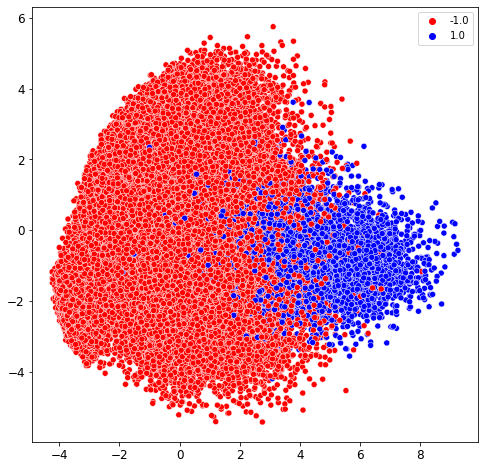

In [25]:
cmap = ListedColormap(['r', 'b'])
plt.figure(figsize=(8,8))
sns.scatterplot(
    x = x_train_pca_2d[:,0], y=x_train_pca_2d[:,1], 
    hue=y_train_0, palette=cmap
);

In [7]:
pipe_pca_3d = make_pipeline(MinMaxScaler(), PCA(n_components=3))
x_train_pca_3d = pipe_pca_3d.fit_transform(x_train)

In [8]:
import plotly.express as px
fig = px.scatter_3d(
    x = x_train_pca_3d[:,0], y = x_train_pca_3d[:,1],
    z = x_train_pca_3d[:,2], color = y_train_0,
    color_discrete_map =cmap, opacity = 0.5
)

fig.show()

#### KNN classifier

In [9]:
pipe_clf_pca_2d = make_pipeline(
    pipe_pca_2d, KNeighborsClassifier(n_neighbors=3)
)

* Let's train a model with 10 samples from training set
* Then test the model with 10 datapoints from the test set

In [10]:
index_neg = np.argsort(y_train_0)[:5]
index_pos = np.argsort(y_train_0)[-1:-6:-1]

Sanity check

In [11]:
#Ensure first 10 samples are mix of both classes
print("Pos classes:", y_train_0[index_pos])
print("Neg classes:", y_train_0[index_neg])

Pos classes: [1. 1. 1. 1. 1.]
Neg classes: [-1. -1. -1. -1. -1.]


In [12]:
# Create a small dataset

x = np.vstack((x_train[index_pos,:], x_train[index_neg,:]))
print(x.shape)
y = np.hstack((y_train_0[index_pos], y_train_0[index_neg]))
print(y.shape)

(10, 784)
(10,)


In [13]:
pipe_clf_pca_2d.fit(x, y)
x_reduced = pipe_clf_pca_2d[0].transform(x)

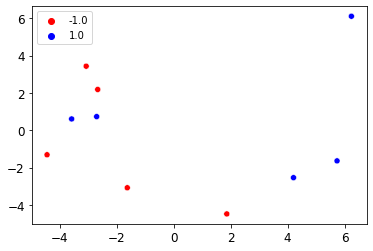

In [26]:
cmap = ListedColormap(['r', 'b'])
plt.figure(figsize=(6,4))
sns.scatterplot(x = x_reduced[:,0], y=x_reduced[:,1], marker ='o', hue=y, palette=cmap);

Test labels: [-1. -1. -1.  1. -1. -1. -1. -1. -1. -1.]


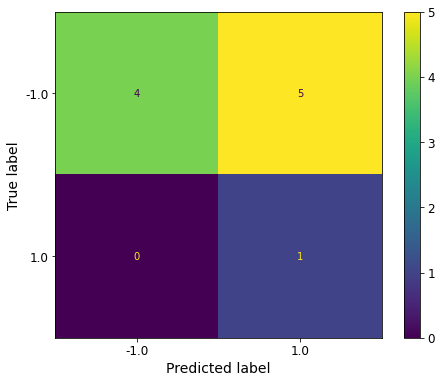

In [15]:
y_hat_0 = pipe_clf_pca_2d.predict(x_test[:10, :])
ConfusionMatrixDisplay.from_predictions(y_test_0[:10], y_hat_0)
print('Test labels:', y_test_0[:10])
plt.show()

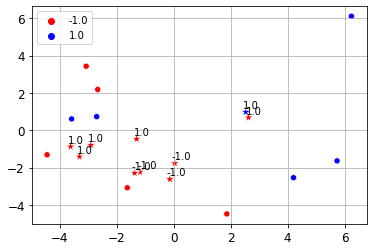

In [16]:
cmap = ListedColormap(['r', 'b'])
plt.figure(figsize=(6,4))
sns.scatterplot(x = x_reduced[:,0], y=x_reduced[:,1], marker ='o', hue=y, palette=cmap)

x_test_reduced = pipe_clf_pca_2d[0].transform(x_test[:10,:])
sns.scatterplot(x = x_test_reduced[:,0], y=x_test_reduced[:,1],s=100, marker ='*', hue=y_test_0[:10], palette=cmap, legend=None)

dx, dy = -0.1, 0.2
for i in range(10):
    plt.annotate(str(y_hat_0[i]), xy = (x_test_reduced[i,0]+dx, x_test_reduced[i, 1]+dy))

plt.grid(True)
plt.show()

* It would be better if we know the distance of 3 neighbours for each test point
* Let us display the distance and connectivity of neighbours to the test datapoints using NearestNeighbour class

In [17]:
from sklearn.neighbors import NearestNeighbors
neighbours = NearestNeighbors(n_neighbors=3)
neighbours.fit(pipe_pca_2d.transform(x))

NearestNeighbors(n_neighbors=3)

In [18]:
dist_neighbours, idx_neighbours = neighbours.kneighbors(
    pipe_pca_2d.transform(x_test[:10]), 3, return_distance=True
)

In [19]:
for i in range(3):
    print('Distance: {0}, \nIndex:{1}, \nLables:{2} \nPrediction: {3} '.format(
        dist_neighbours[i], idx_neighbours[i], 
        y[idx_neighbours[i].flatten()],
        stats.mode(y[idx_neighbours[i].flatten()]).mode[0]
    ))


Distance: [1.54510433 1.56004731 1.61914472], 
Index:[1 4 6], 
Lables:[ 1.  1. -1.] 
Prediction: 1.0 
Distance: [0.95703587 3.33077652 3.39001596], 
Index:[7 1 6], 
Lables:[-1.  1. -1.] 
Prediction: -1.0 
Distance: [1.14297879 2.0379748  2.22709669], 
Index:[6 4 1], 
Lables:[-1.  1.  1.] 
Prediction: 1.0 


In [20]:
pipe_clf_pca_2d.fit(x_train[:10000], y_train_0[:10000])

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                 ('pca', PCA(n_components=2))])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

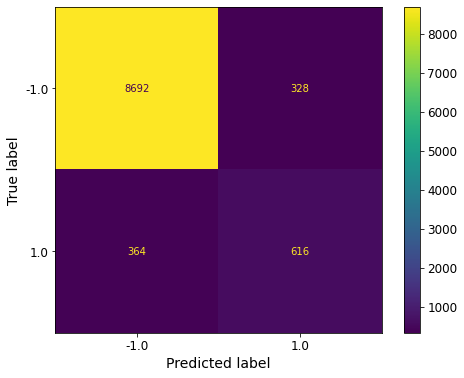

In [21]:
y_hat_0 = pipe_clf_pca_2d.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test_0, y_hat_0)
plt.show()

In [22]:
print(classification_report(y_test_0, y_hat_0))

              precision    recall  f1-score   support

        -1.0       0.96      0.96      0.96      9020
         1.0       0.65      0.63      0.64       980

    accuracy                           0.93     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.93      0.93      0.93     10000



Vary the n_neighbors from k = 1, 19 and study the performance of the model. 

In [23]:
precision = []
for k in range(1, 20, 2):
    pipe_clf_pca_2d.__n_neighbors = k
    pipe_clf_pca_2d.fit(x_train[:10000], y_train_0[:10000])
    y_hat_0 = pipe_clf_pca_2d.predict(x_test)
    precision.append(precision_score(y_test_0, y_hat_0))

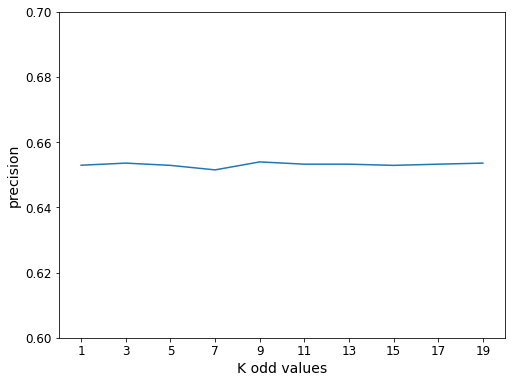

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 20, 2), precision); 
plt.xlim((0, 20))
plt.ylim((0.6, 0.7))
plt.xlabel('K odd values')
plt.ylabel('precision')
plt.xticks(ticks=np.arange(1, 20, 2), labels=np.arange(1, 20, 2))
plt.show()

#### Going without PCA

In [32]:
pipe_knn = make_pipeline(
    MinMaxScaler(), KNeighborsClassifier(n_neighbors=1)
)

In [33]:
grid_k = {"kneighborsclassifier__n_neighbors" : [1, 3, 5, 7, 9, 11]}

cv = GridSearchCV(
    pipe_knn, param_grid= grid_k, scoring= 'precision', cv = 5
)
cv.fit(x_train, y_train_0)
print(cv)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_neighbors=1))]),
             param_grid={'kneighborsclassifier__n_neighbors': [1, 3, 5, 7, 9,
                                                               11]},
             scoring='precision')


In [34]:
print(cv.cv_results_)

{'mean_fit_time': array([1.40323706, 1.09860158, 1.09475298, 1.10185423, 0.99101348,
       1.09474239]), 'std_fit_time': array([0.70482558, 0.02458188, 0.01437642, 0.0343378 , 0.21224341,
       0.02091877]), 'mean_score_time': array([34.33587565, 33.69208922, 38.09306903, 38.3651679 , 38.60780315,
       39.26602554]), 'std_score_time': array([6.58007076, 0.14353601, 0.79867558, 1.00104009, 1.04182954,
       0.55782548]), 'param_kneighborsclassifier__n_neighbors': masked_array(data=[1, 3, 5, 7, 9, 11],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'kneighborsclassifier__n_neighbors': 1}, {'kneighborsclassifier__n_neighbors': 3}, {'kneighborsclassifier__n_neighbors': 5}, {'kneighborsclassifier__n_neighbors': 7}, {'kneighborsclassifier__n_neighbors': 9}, {'kneighborsclassifier__n_neighbors': 11}], 'split0_test_score': array([0.97920133, 0.98493724, 0.98166667, 0.98086522, 0.97921862,
       0.97921862]), 'sp

In [35]:
cv.best_estimator_

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=7))])

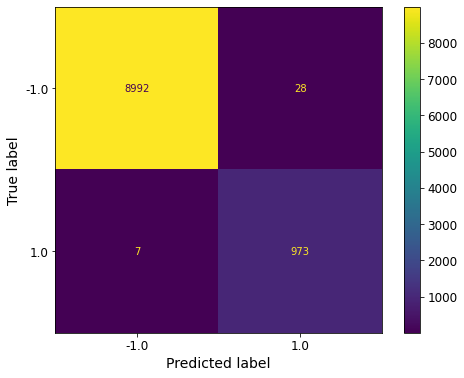

In [37]:
y_hat_0 = cv.best_estimator_.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test_0, y_hat_0)
plt.show();

### Multiclass classification

In [42]:
pipe_knn = cv.best_estimator_
print(pipe_knn)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=7))])


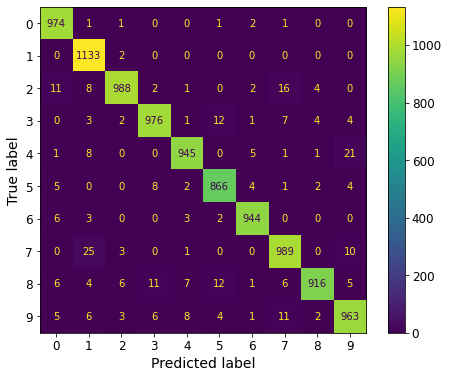

In [43]:
pipe_knn.fit(x_train, y_train)
y_hat = pipe_knn.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_hat)
plt.show();

In [44]:
pipe_knn.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [45]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.95      1.00      0.97      1135
           2       0.98      0.96      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.96      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



we get very good numbers here 